In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping




In [2]:
"Read in data"
df = pd.read_csv("car_sales_data.csv")

In [3]:
print("Shape:", df.shape)
print("\nColumns & dtypes:\n", df.dtypes)

Shape: (50000, 7)

Columns & dtypes:
 Manufacturer            object
Model                   object
Engine size            float64
Fuel type               object
Year of manufacture      int64
Mileage                  int64
Price                    int64
dtype: object


In [4]:
"Adding features"

age = df["Car_Age"] = 2022 - df["Year of manufacture"] # avoid division by zero -> turn 0 age into NaN

df["Mileage_per_Year"] = df["Mileage"].div(age)

# replace any remaining inf with NaN, then fill with total mileage
df["Mileage_per_Year"] = (
    df["Mileage_per_Year"]
      .replace([np.inf, -np.inf], np.nan)
      .fillna(df["Mileage"])
)


In [5]:
#check duplicates
print("Total duplicates:", df.duplicated().sum())


duplicates = df[df.duplicated()] #display all duplicate rows
print(duplicates)


Total duplicates: 12
      Manufacturer   Model  Engine size Fuel type  Year of manufacture  \
5426            VW    Polo          1.2    Petrol                 2003   
9862          Ford  Mondeo          1.4    Diesel                 1987   
14745          BMW      Z4          2.4    Petrol                 1999   
19020       Toyota   Yaris          1.0    Petrol                 1996   
19337           VW    Polo          1.0    Petrol                 2000   
23927           VW    Polo          1.2    Petrol                 2021   
25368           VW    Golf          1.2    Diesel                 2011   
28576           VW    Polo          1.2    Petrol                 2003   
34246           VW  Passat          2.0    Diesel                 2003   
35647         Ford   Focus          1.6    Petrol                 2019   
41536           VW  Passat          1.8    Diesel                 1996   
45904         Ford  Fiesta          1.2    Petrol                 2003   

       Mileage  

In [6]:
"Duplicates"

#drop duplicates
df = df.drop_duplicates()

print("After dropping exact duplicates:", df.shape)


After dropping exact duplicates: (49988, 9)


In [7]:
"check missing values per column"

print("\nMissing values per column:\n", df.isna().sum())

inf_counts = np.isinf(df.select_dtypes(include=[np.number])).sum()
print("\nInfinite values per numeric column:\n", inf_counts)

# Combined check (NaN + Inf)
bad_values = df.isna().sum() + np.isinf(df.select_dtypes(include=[np.number])).reindex(df.columns, fill_value=0)
print("\nTotal problematic values (NaN + Inf) per column:\n", bad_values)



Missing values per column:
 Manufacturer           0
Model                  0
Engine size            0
Fuel type              0
Year of manufacture    0
Mileage                0
Price                  0
Car_Age                0
Mileage_per_Year       0
dtype: int64

Infinite values per numeric column:
 Engine size            0
Year of manufacture    0
Mileage                0
Price                  0
Car_Age                0
Mileage_per_Year       0
dtype: int64

Total problematic values (NaN + Inf) per column:
                     Car_Age Engine size  Fuel type  Manufacturer Mileage  \
Manufacturer              0           0        NaN           NaN       0   
Model                     0           0        NaN           NaN       0   
Engine size               0           0        NaN           NaN       0   
Fuel type                 0           0        NaN           NaN       0   
Year of manufacture       0           0        NaN           NaN       0   
Mileage                  

# Data visualisations

Cars per manufacturer:
              Count  Percentage
Manufacturer                   
Ford          14956       29.92
VW            14906       29.82
Toyota        12553       25.11
BMW            4964        9.93
Porsche        2609        5.22


/var/folders/by/bn5byyk92gq6f173m_jc7qym0000gn/T/ipykernel_45169/238748735.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


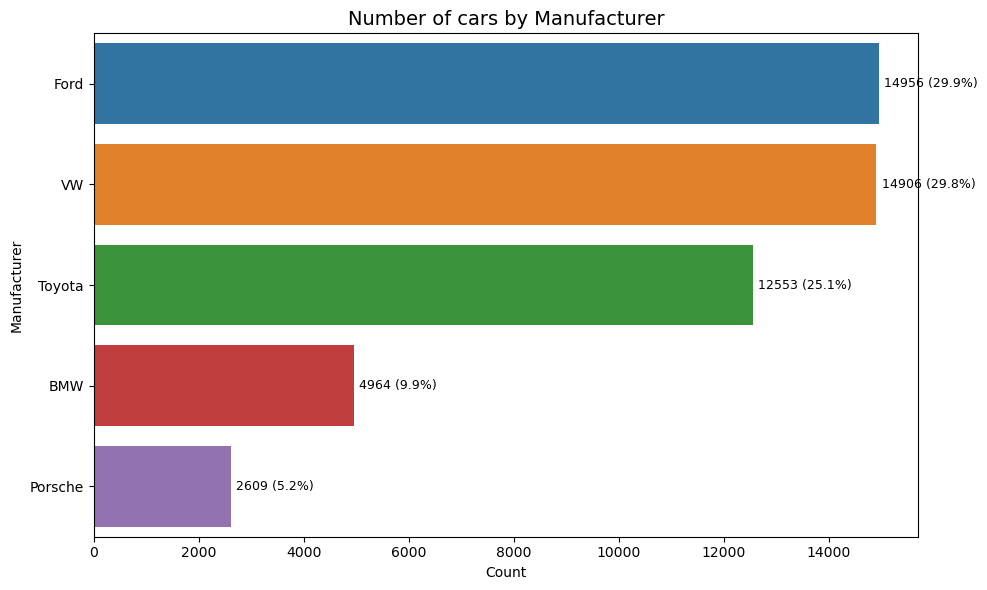

In [8]:
"Number and percentage of every manufacturer"

# Group by manufacturer and count
counts = df["Manufacturer"].value_counts()

counts_df = counts.rename("Count").to_frame()
counts_df["Percentage"] = (counts_df["Count"] / counts_df["Count"].sum() * 100).round(2)

print("Cars per manufacturer:")
print(counts_df)

#plot
plt.figure(figsize=(10,6))
palette = sns.color_palette("tab10", n_colors=len(counts_df))

sns.barplot(
    y=counts_df.index,
    x=counts_df["Count"],
    palette=palette
)

plt.title("Number of cars by Manufacturer", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Manufacturer")

for i, (count, pct) in enumerate(zip(counts_df["Count"], counts_df["Percentage"])):
    plt.text(count + 100, i, f"{count} ({pct:.1f}%)",
             ha="left", va="center", fontsize=9)

plt.tight_layout()
plt.show()



Sorted with percentages:

Manufacturer      Model  count  percentage
         BMW         Z4   1687       33.98
         BMW         M5   1645       33.14
         BMW         X3   1632       32.88
        Ford     Mondeo   5057       33.81
        Ford      Focus   4975       33.26
        Ford     Fiesta   4924       32.92
     Porsche        911    872       33.42
     Porsche    Cayenne    870       33.35
     Porsche 718 Cayman    867       33.23
      Toyota       RAV4   4292       34.19
      Toyota      Prius   4171       33.23
      Toyota      Yaris   4090       32.58
          VW       Golf   5049       33.87
          VW       Polo   4988       33.46
          VW     Passat   4869       32.66


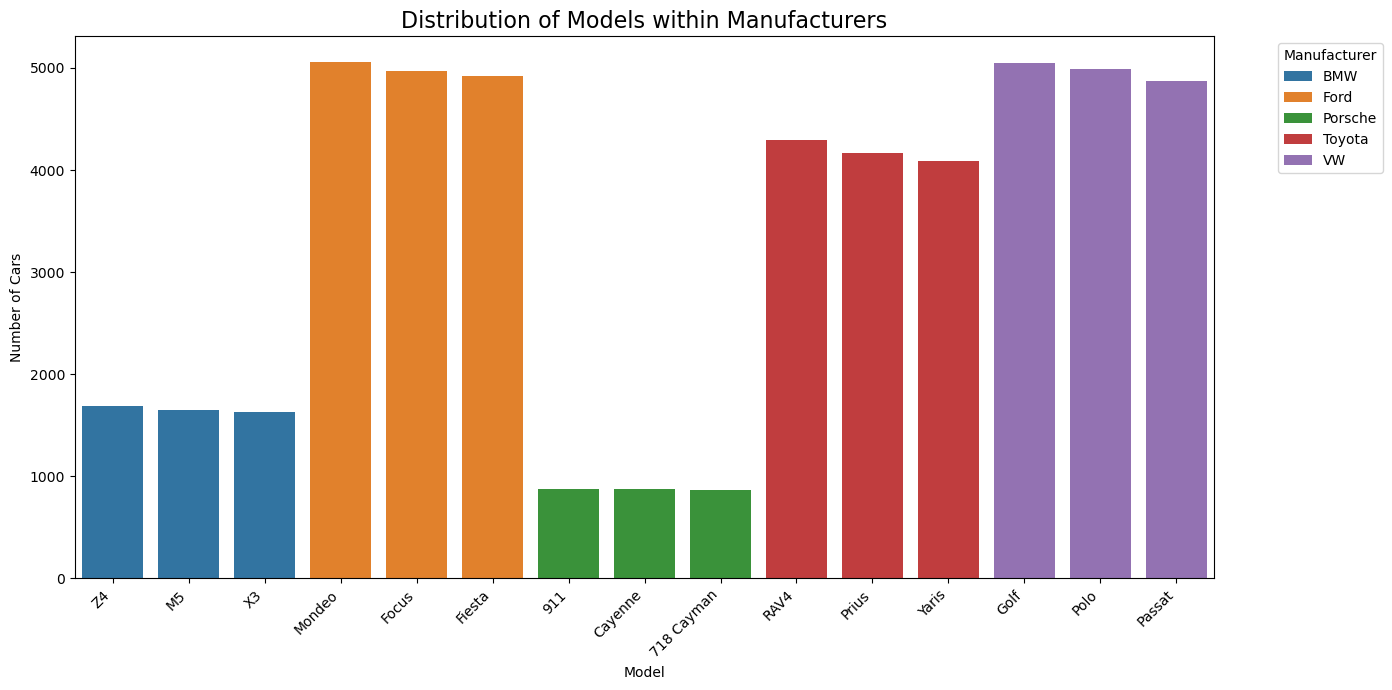

In [9]:
"Number and percentage of every model"

#Group by Manufacturer and Model
brand_model_counts = (
    df.groupby(["Manufacturer", "Model"])
      .size()
      .reset_index(name="count")
)

brand_model_counts["percentage"] = (
    brand_model_counts
    .groupby("Manufacturer")["count"]
    .transform(lambda x: (x / x.sum() * 100).round(2))
)

#Sort by manufacturer
brand_model_counts = brand_model_counts.sort_values(
    ["Manufacturer", "count"], ascending=[True, False]
).reset_index(drop=True)

print("\nSorted with percentages:\n")
print(brand_model_counts.to_string(index=False))

#Plot
plt.figure(figsize=(14, 7))
sns.barplot(
    data=brand_model_counts,
    x="Model",
    y="count",
    hue="Manufacturer",
    dodge=False,
    palette="tab10"
)
plt.title("Distribution of Models within Manufacturers", fontsize=16)
plt.ylabel("Number of Cars")
plt.xlabel("Model")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Manufacturer", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [10]:
"Identify numeric and categorical cols"

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)



Numeric columns: ['Engine size', 'Year of manufacture', 'Mileage', 'Price', 'Car_Age', 'Mileage_per_Year']
Categorical columns: ['Manufacturer', 'Model', 'Fuel type']


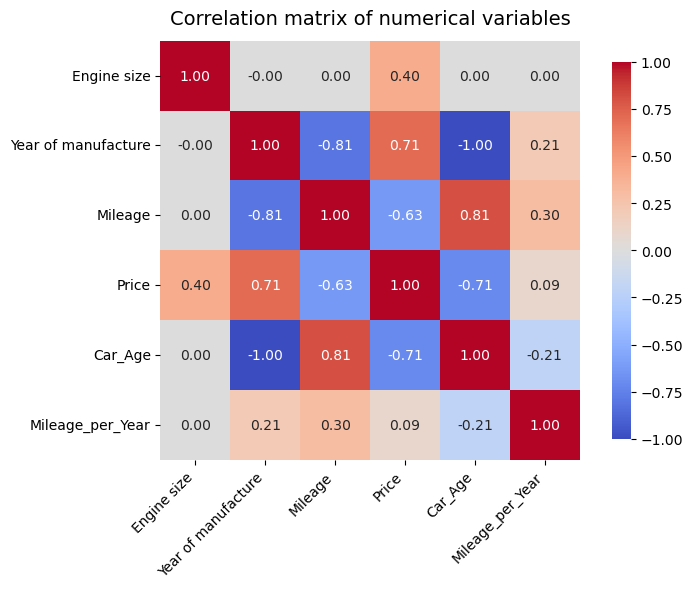

In [11]:
"Correlation matrix of numerical fuetures"

#only numeric columns
numeric_cols = df.select_dtypes(include=[np.number])

corr = numeric_cols.corr(method="pearson").round(2)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    corr,
    annot=True, fmt=".2f",
    cmap="coolwarm", vmin=-1, vmax=1,
    square=True,
    cbar_kws={"shrink": 0.9}
)
ax.set_title("Correlation matrix of numerical variables", fontsize=14, pad=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Training NN

In [12]:
"Configure features and target"
# Define target column
target_col = "Price"

# Split features/target
x = df.drop(columns=[target_col])
y = df[target_col].astype(float)

In [13]:
"Split data into training and test sets"
# Split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

In [14]:
"Preprocess data"
print(f"Original X_train shape: {X_train.shape}")
print(f"Data types:\n{X_train.dtypes}")


# One-hot encoding for categorical variables
X_train_processed = pd.get_dummies(X_train, drop_first=True)
X_test_processed = pd.get_dummies(X_test, drop_first=True)

# Update variables for cross-validation
X_train = X_train_processed
X_test = X_test_processed

Original X_train shape: (39990, 8)
Data types:
Manufacturer            object
Model                   object
Engine size            float64
Fuel type               object
Year of manufacture      int64
Mileage                  int64
Car_Age                  int64
Mileage_per_Year       float64
dtype: object


In [15]:
"Cross-validation setup"
k_folds = 5 # Number of folds
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Define parameter grid to test 
param_combinations = [
    {'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'hidden_size': 64},
    {'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'hidden_size': 128},
    {'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'hidden_size': 64},
]


In [16]:
"Cross-validation function"
def cv_params(X_train, y_train, param_list, k_folds=5):
    """Cross-validation for neural network hyperparameters"""
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    best_score, best_params = float('inf'), None
    
    for i, params in enumerate(param_list):
        print(f"\nTesting {i+1}/{len(param_list)}: {params}")
        scores = []
        
        # Split and scale data
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
            scaler = StandardScaler()
            X_tr = scaler.fit_transform(X_train.iloc[train_idx])
            X_val = scaler.transform(X_train.iloc[val_idx])
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            # Build model
            model = Sequential([
                Dense(params['hidden_size'], activation='relu', input_dim=X_tr.shape[1]),
                Dense(params['hidden_size']//2, activation='relu'),
                Dense(params['hidden_size']//4, activation='relu'),
                Dense(1)
            ])
            model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='mse')
            
            # Train
            model.fit(X_tr, y_tr, epochs=params['epochs'], batch_size=params['batch_size'],
                     validation_data=(X_val, y_val), verbose=0,
                     callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])
            
            # Evaluate
            score = mean_squared_error(y_val, model.predict(X_val, verbose=0))
            scores.append(score)
            print(f"  Fold {fold+1}: {score:.4f}")
        
        # Track best
        avg_score = np.mean(scores)
        print(f"  Average: {avg_score:.4f} ± {np.std(scores):.4f}")
        
        if avg_score < best_score:
            best_score, best_params = avg_score, params
    
    print(f"Best: {best_params} (MSE: {best_score:.4f})")
    return best_params, best_score, []

In [17]:
"Run cross-validation to find best parameters"
best_params, best_score, all_results = cv_params(
    X_train, y_train, 
    param_combinations, 
    k_folds=5
)

print("\nAll parameter combinations tested:")
for i, result in enumerate(all_results):
    print(f"\n{i+1}. {result['params']}")
    print(f"   Average MSE: {result['avg_score']:.4f} ± {result['std_score']:.4f}")
    print(f"   Fold scores: {[f'{score:.4f}' for score in result['fold_scores']]}")

# Print best parameters
print(f"   BEST PARAMETERS FOUND:")
print(f"   Parameters: {best_params}")
print(f"   Best CV Score (MSE): {best_score:.4f}")
print(f"   Best CV Score (RMSE): {np.sqrt(best_score):.4f}")



Testing 1/3: {'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'hidden_size': 64}


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 1: 39613.9283


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 2: 53142.4972


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 3: 44123.1402


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 4: 45826.2667


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 5: 53581.5957
  Average: 47257.4856 ± 5383.7572

Testing 2/3: {'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'hidden_size': 128}


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 1: 75266.0938


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 2: 39079.9196


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 3: 100537.6447


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 4: 52540.9265


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 5: 116274.4108
  Average: 76739.7991 ± 28758.8134

Testing 3/3: {'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'hidden_size': 64}


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 1: 36333.8531


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 2: 35825.6317


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 3: 27349.0711


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 4: 36639.5691


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 5: 31302.3822
  Average: 33490.1015 ± 3632.0557
Best: {'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'hidden_size': 64} (MSE: 33490.1015)

All parameter combinations tested:
   BEST PARAMETERS FOUND:
   Parameters: {'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'hidden_size': 64}
   Best CV Score (MSE): 33490.1015
   Best CV Score (RMSE): 183.0030


In [18]:
"Training final model with best parameters"

# Scale the full training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create final model with best params
def create_final_model(params, input_dim):
    model = Sequential([
        Dense(params['hidden_size'], activation='relu', input_dim=input_dim),
        Dense(params['hidden_size']//2, activation='relu'),
        Dense(params['hidden_size']//4, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=params['learning_rate']),
        loss='mse',
        metrics=['mae']
    )
    return model

# Train final model
final_model = create_final_model(best_params, X_train_scaled.shape[1])

history = final_model.fit(
    X_train_scaled, y_train,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    validation_split=0.2,  # Use 20% of training data for monitoring
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)]
)

print("Final model training complete!")

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 553us/step - loss: 427746240.0000 - mae: 12972.3633 - val_loss: 53090792.0000 - val_mae: 3752.9990
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 48618040.0000 - mae: 3546.5242 - val_loss: 30259942.0000 - val_mae: 2739.8665
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 30183576.0000 - mae: 2771.8350 - val_loss: 22792198.0000 - val_mae: 2302.6782
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 22193198.0000 - mae: 2239.5471 - val_loss: 18360736.0000 - val_mae: 1869.1898
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 18667454.0000 - mae: 1785.0769 - val_loss: 15145121.0000 - val_mae: 1410.6776
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 15431081.0000 - mae: 1471.3361 - val_loss: 12104995.0000 - val_mae: 1188.2415
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 12796057.0000 - mae: 1240.5997 - val_loss: 9086821.0000 - val_mae: 1005.7105
Epoch 8/100
500/500 ━━━━

   Final test results:
   Mean Squared Error (MSE): 34719.9909
   Root Mean Squared Error (RMSE): 186.3330
   Mean Absolute Error (MAE): 117.8184
   R² Score: 0.9999
   Comparison:
   Cross-Validation RMSE: 183.0030
   Final Test RMSE: 186.3330
   Difference: 3.3300


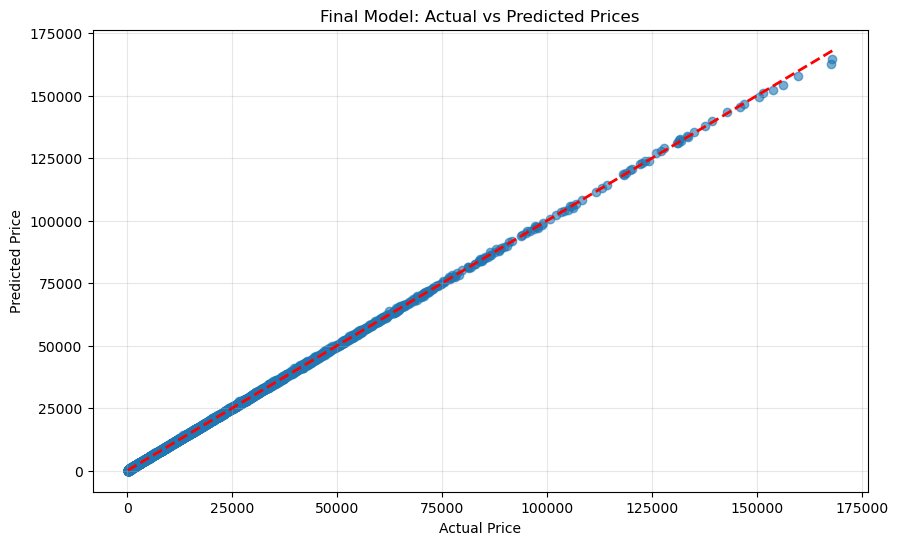

In [19]:
"Evaluate final model on test set"

# Make predictions on test set
test_predictions = final_model.predict(X_test_scaled, verbose=0)

# Calculate metrics
mse = mean_squared_error(y_test, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, test_predictions)
r2 = r2_score(y_test, test_predictions)

# Print results
print(f"   Final test results:")
print(f"   Mean Squared Error (MSE): {mse:.4f}")
print(f"   Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"   Mean Absolute Error (MAE): {mae:.4f}")
print(f"   R² Score: {r2:.4f}")

print(f"   Comparison:")
print(f"   Cross-Validation RMSE: {np.sqrt(best_score):.4f}")
print(f"   Final Test RMSE: {rmse:.4f}")
print(f"   Difference: {abs(rmse - np.sqrt(best_score)):.4f}")

# Plot (predictions vs actual)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Final Model: Actual vs Predicted Prices')
plt.grid(True, alpha=0.3)
plt.show()


In [20]:
"Save model"
final_model.save('price_prediction_model.keras') 

# Save scaler
joblib.dump(scaler, 'scaler.joblib')

# Metadata
model_info = {
    'best_params': best_params,
    'best_score': best_score,
    'feature_names': list(X_train.columns),
    'model_type': 'neural_network'
}
joblib.dump(model_info, 'model_info.joblib')

['model_info.joblib']

In [21]:
"Function to predict on new data"
def predict_price(new_data):
    new_data_scaled = scaler.transform(new_data)
    prediction = final_model.predict(new_data_scaled)
    return prediction[0][0]

In [22]:
"Example"
new_car_data = pd.DataFrame({
    'Make': ['Toyota'],
    'Model': ['Camry'], 
    'Year': [2023],
    'Mileage': [25000],
    'Engine_Size': [2.5],
})

In [23]:
"Test prediction on samples from test set"

sample_new_data = X_test.iloc[:5].copy()  # Test samples
actual_prices = y_test.iloc[:5].copy()    # Actual prices (for comparison)


for i in range(len(sample_new_data)):
    sample_scaled = scaler.transform([sample_new_data.iloc[i]])
    
    # Make prediction
    predicted_price = final_model.predict(sample_scaled, verbose=0)[0][0]
    actual_price = actual_prices.iloc[i]
    
    print(f"Sample {i+1}:")
    print(f"  Predicted Price: ${predicted_price:,.2f}")
    print(f"  Actual Price: ${actual_price:,.2f}")
    print(f"  Error: ${abs(predicted_price - actual_price):,.2f}")
    print()

Sample 1:
  Predicted Price: $28,855.22
  Actual Price: $28,636.00
  Error: $219.22

Sample 2:
  Predicted Price: $60,137.87
  Actual Price: $59,783.00
  Error: $354.87

Sample 3:
  Predicted Price: $14,901.35
  Actual Price: $14,865.00
  Error: $36.35

Sample 4:
  Predicted Price: $2,246.61
  Actual Price: $2,219.00
  Error: $27.61

Sample 5:
  Predicted Price: $1,029.94
  Actual Price: $1,001.00
  Error: $28.94



/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [24]:
"SHAP"
# Use smaller sample for faster computation
n_background = 50  # Background samples
n_explain = 10     # Samples to explain

# Create wrapper function
def model_predict_shap(X):
    return final_model.predict(X, verbose=0).flatten()

# Use KernelExplainer instead of DeepExplainer
explainer = shap.KernelExplainer(model_predict_shap, X_train_scaled[:n_background])
shap_values = explainer.shap_values(X_test_scaled[:n_explain])

# Simple feature importance from SHAP
feature_importance = np.mean(np.abs(shap_values), axis=0)
shap_df = pd.DataFrame({
    'Feature': X_train.columns,
    'SHAP_Importance': feature_importance
}).sort_values('SHAP_Importance', ascending=False)

print("Top 10 Features by SHAP:")
print(shap_df.head(10))

  0%|          | 0/10 [00:00<?, ?it/s]

Top 10 Features by SHAP:
                 Feature  SHAP_Importance
2                Mileage      5819.177223
1    Year of manufacture      5491.764885
3                Car_Age      5022.531320
14              Model_M5      4045.120942
0            Engine size      2884.336018
19            Model_RAV4      1218.063513
6   Manufacturer_Porsche       924.109092
15          Model_Mondeo       809.510184
12           Model_Focus       713.965243
23      Fuel type_Hybrid       630.179722


In [ ]:

"ANVÄND FÖR RAPPORT"

# Calculate SHAP feature importance (your existing code)
feature_importance = np.mean(np.abs(shap_values), axis=0)
shap_df = pd.DataFrame({
    'Feature': X_train.columns,
    'SHAP_Importance': feature_importance
}).sort_values('SHAP_Importance', ascending=False)

# Much clearer output
print("=" * 70)
print("🎯 SHAP FEATURE IMPORTANCE ANALYSIS")
print("=" * 70)
print("Ranking features by their average impact on price predictions")
print("Higher values = more influential on model decisions")
print()

print("📊 TOP 15 MOST INFLUENTIAL FEATURES:")
print("-" * 70)
print(f"{'Rank':>4} {'Feature':.<35} {'SHAP Score':>12} {'% of Total':>10}")
print("-" * 70)

# Calculate percentages
total_importance = shap_df['SHAP_Importance'].sum()

for i, (idx, row) in enumerate(shap_df.head(15).iterrows(), 1):
    feature = row['Feature']
    importance = row['SHAP_Importance']
    percentage = (importance / total_importance) * 100
    
    print(f"{i:>4}. {feature:.<34} {importance:>10.1f} {percentage:>8.1f}%")

print("-" * 70)
print(f"{'':>4} {'TOTAL (Top 15)':.<34} {shap_df.head(15)['SHAP_Importance'].sum():>10.1f} {(shap_df.head(15)['SHAP_Importance'].sum()/total_importance)*100:>8.1f}%")

# Key insights
print()
print("🔍 KEY INSIGHTS:")
top_3 = shap_df.head(3)
print(f"• Top 3 features ({', '.join(top_3['Feature'].tolist())}) account for {(top_3['SHAP_Importance'].sum()/total_importance)*100:.1f}% of model decisions")
print(f"• {shap_df['Feature'].iloc[0]} is the most critical factor (index {shap_df.index[0]})")
print(f"• Model uses {len(shap_df)} total features, but top 10 drive {(shap_df.head(10)['SHAP_Importance'].sum()/total_importance)*100:.1f}% of predictions")

print()
print("💡 INTERPRETATION:")
print("• Physical wear (Mileage, Car_Age) dominate pricing decisions")
print("• Luxury models (M5, Porsche) create significant price premiums")  
print("• Brand and model matter more than basic specs")

🎯 SHAP FEATURE IMPORTANCE ANALYSIS
Ranking features by their average impact on price predictions
Higher values = more influential on model decisions

📊 TOP 15 MOST INFLUENTIAL FEATURES:
----------------------------------------------------------------------
Rank Feature............................   SHAP Score % of Total
----------------------------------------------------------------------
   1. Mileage...........................     5819.2     19.2%
   2. Year of manufacture...............     5491.8     18.1%
   3. Car_Age...........................     5022.5     16.6%
   4. Model_M5..........................     4045.1     13.4%
   5. Engine size.......................     2884.3      9.5%
   6. Model_RAV4........................     1218.1      4.0%
   7. Manufacturer_Porsche..............      924.1      3.1%
   8. Model_Mondeo......................      809.5      2.7%
   9. Model_Focus.......................      714.0      2.4%
  10. Fuel type_Hybrid..................      630

  Processed 1/25 features...
  Processed 11/25 features...
  Processed 21/25 features...
✅ Feature importance calculated!


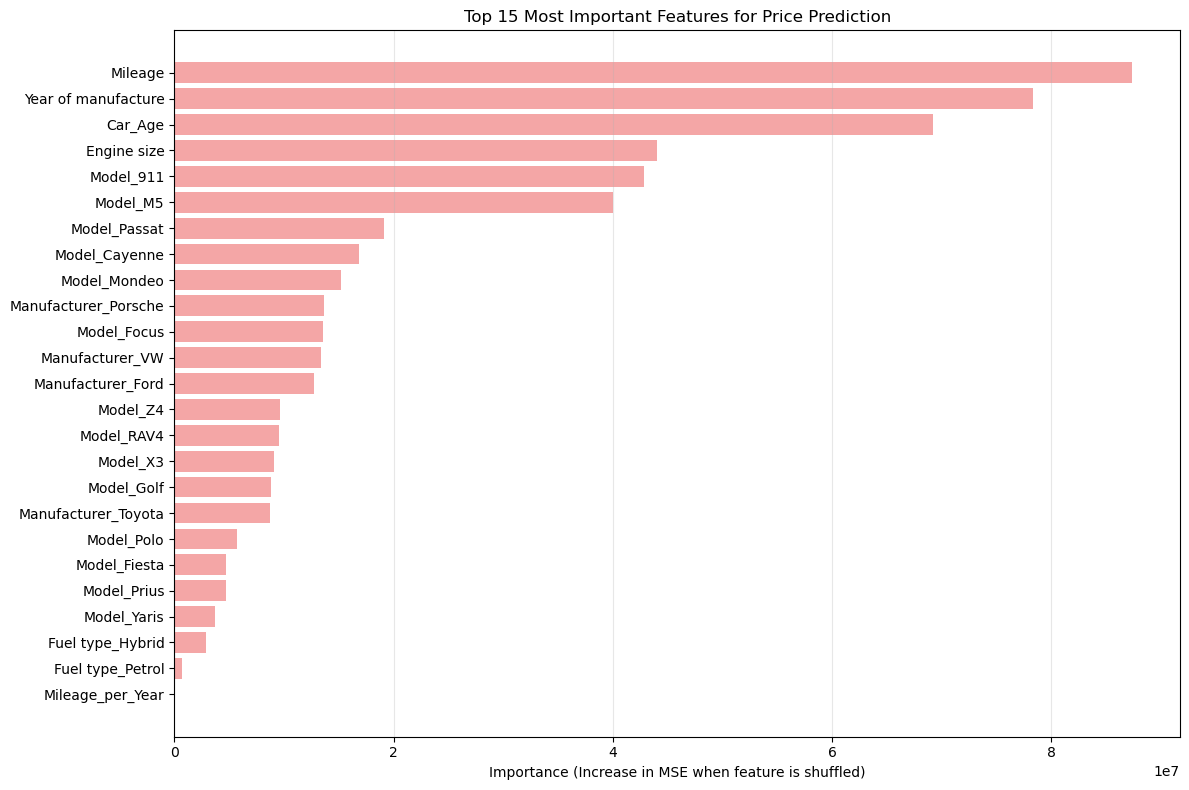

Most Important Features:
 1. Mileage                             87376675.5692
 2. Year of manufacture                 78361353.5006
 3. Car_Age                             69221084.1215
 4. Engine size                         44011494.1071
 5. Model_911                           42810954.7139
 6. Model_M5                            40039405.6457
 7. Model_Passat                        19163213.6449
 8. Model_Cayenne                       16885988.4550
 9. Model_Mondeo                        15185532.4673
10. Manufacturer_Porsche                13660516.3282
11. Model_Focus                         13584828.9547
12. Manufacturer_VW                     13410865.4790
13. Manufacturer_Ford                   12783831.3711
14. Model_Z4                            9669250.6969
15. Model_RAV4                          9532028.5312
16. Model_X3                            9080982.6494
17. Model_Golf                          8819283.3579
18. Manufacturer_Toyota                 8712289.7016
19. Mode

In [26]:
"Feature importance by permutation"
baseline_predictions = final_model.predict(X_test_scaled, verbose=0).flatten()
baseline_mse = mean_squared_error(y_test, baseline_predictions)

# Calculate importance for each feature
feature_importance_scores = []

for i, feature_name in enumerate(X_train.columns):
    X_test_permuted = X_test_scaled.copy()
    np.random.seed(42)
    X_test_permuted[:, i] = np.random.permutation(X_test_permuted[:, i])
    
    # Make predictions with shuffled feature
    permuted_predictions = final_model.predict(X_test_permuted, verbose=0).flatten()
    permuted_mse = mean_squared_error(y_test, permuted_predictions)
    
    # Calculate importance (increase in error)
    importance = permuted_mse - baseline_mse
    feature_importance_scores.append(importance)
    
    if i % 10 == 0: 
        print(f"  Processed {i+1}/{len(X_train.columns)} features...")

# Results dataframe
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance_scores
}).sort_values('Importance', ascending=False)

print("✅ Feature importance calculated!")

# Plot (top features)
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(100)

plt.barh(range(len(top_features)), top_features['Importance'], 
         alpha=0.7, color='lightcoral')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance (Increase in MSE when feature is shuffled)')
plt.title('Top 15 Most Important Features for Price Prediction')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


print("Most Important Features:")
for i, (idx, row) in enumerate(feature_importance_df.head(100).iterrows()):
    print(f"{i+1:2d}. {row['Feature']:35} {row['Importance']:8.4f}")

print(f"\nInterpretation:")
print(f"- Higher values = more important for accurate predictions")
print(f"- These features cause the biggest performance drop when shuffled")
print(f"- Negative values mean shuffling actually improved performance (rare)")

# Percentage contribution
total_importance = feature_importance_df['Importance'].sum()
feature_importance_df['Percentage'] = (feature_importance_df['Importance'] / total_importance * 100).round(2)

print(f"\nTop 5 Features by Percentage Contribution:")
for i, (idx, row) in enumerate(feature_importance_df.head(5).iterrows()):
    print(f"{i+1}. {row['Feature']:35} {row['Percentage']:5.1f}%")